In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [54]:
def load_and_prep_image(filename, img_shape=(128,800)):
    img = cv2.imread(filename)
    img = cv2.resize(img, (800, 128))
    img = img/255.
    return img

In [55]:
def pred_and_plot(model, filename, class_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = class_names[int(tf.round(pred)[0][0])]
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    return np.argmax(pred)

In [39]:
def rle2mask(rle):
    if rle==0:
        return np.zeros((128, 800), dtype=np.uint8)
    
    height = 128
    width = 800
    mask = np.zeros(width*height, dtype=np.uint8)
    
    starts_lengths = np.asarray([int(x) for x in rle.split()])
    starts = starts_lengths[0::2]-1 
    lengths = starts_lengths[1::2] 
    for idx, start in enumerate(starts):
        mask[int(start): int(start+lengths[idx])] = 1
        
    
    return mask.reshape((height, width), order='F')[::2, ::2]

def mask2contour(mask, width=3):
    w = mask.shape[1]
    h = mask.shape[0]
    
    mask2 = np.concatenate([mask[:, width:], np.zeros((h, width))], axis=1)
    mask2 = np.logical_xor(mask, mask2)
    mask3 = np.concatenate([mask[width:, :], np.zeros((width, w))], axis=0)
    mask3 = np.logical_xor(mask, mask3)
    
    return np.logical_or(mask2, mask3)

def mask_padding(mask, pad=2):
    w = mask.shape[1]
    h = mask.shape[0]
    
    for i in range(1, pad, 2):
        temp = np.concatenate([mask[i:, :], np.zeros((i, w))], axis=0)
        mask = np.logical_or(mask, temp)
   
    for i in range(1, pad, 2):
        temp = np.concatenate([np.zeros((i, w)), mask[:-i, :]], axis=0)
        mask = np.logical_or(mask, temp)
    
    for i in range(1, pad, 2):
        temp = np.concatenate([mask[:, i:], np.zeros((h, i))], axis=1)
        mask = np.logical_or(mask, temp)
    
    for i in range(1, pad, 2):
        temp = np.concatenate([np.zeros((h, i)), mask[:, :-i]], axis=1)
        mask = np.logical_or(mask, temp)
    
    return mask

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [24]:
def load_models(classify_model_pth="models/defect_classify", segment_model_pth="models/segmentation/segment_model.h5"):
    classify_model = tf.keras.models.load_model(classify_model_pth)
    segment_model = tf.keras.models.load_model(segment_model_pth, custom_objects={"dice_coef":dice_coef})
    return classify_model, segment_model

In [30]:
def classify_inference(model, img_path="data/train_images/0a3bbea4d.jpg"):
    class_names = ["1", "2", "3", "4"]

    output_class = pred_and_plot(model=model, 
                filename=img_path, 
                class_names=class_names)
    return output_class

In [84]:
def segment_inference(segment_model, img_path="data/train_images/0a3bbea4d.jpg"):
    img = cv2.imread(img_path)
    img = img.copy()
    img = cv2.resize(img, (800, 128))
    res=segment_model.predict(np.expand_dims(img,axis=0))
    res_bool = (res>0.5).astype(np.uint8)[0]
    defect = []
    for j in range(4):
        msk = res_bool[:,..., j]
        msk = mask_padding(msk)
        msk = mask2contour(msk)
        if np.sum(msk) != 0:
            defect.append(j+1)
        if j == 0:
            img[msk==1] = 1, 0, 0
        elif j == 1:
            img[msk==1] = 0, 1, 0
        elif j == 2:
            img[msk==1] = 1, 1, 0
        elif j == 3:
            img[msk==1] = 1, 0, 1
            
    plt.title(f'defect: {defect}')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

2

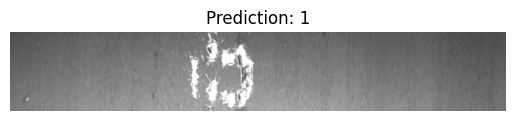

In [95]:
classify_model, segment_model = load_models()
image_to_predict = "data/train_images/ffe93442c.jpg"
classify_inference(classify_model, img_path=image_to_predict)


1/1 [==============================] - 1s 954ms/step


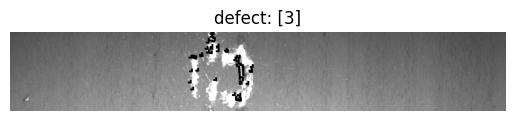

In [96]:
segment_inference(segment_model, img_path=image_to_predict)